In [1]:
import os
import numpy as np
from itertools import islice
import pandas as pd

path = './sims/output/'
extension = '.mco'
dirs = [e.name for e in os.scandir(path)]

wls = np.arange(740, 902, 2)
bin_size = 0.05
dists = np.arange(99)*bin_size
reflectance_lines = 99 # ignore the overflow bin
reflectance_col_header = "Rd_r #Rd[0], [1],..Rd[nr-1]. [1/cm2]\n"

def read_reflectance_data(folder):
    file_names = [folder + '_' + str(e) for e in range(len(wls))]

    result = np.zeros((len(wls), len(dists)))

    for i in range(len(wls)):
        with open(path + folder + '/' + file_names[i] + extension) as lines:
            read_file = lines.readlines()
            col_i = read_file.index(reflectance_col_header)
            result[i, :] = np.genfromtxt(read_file[col_i+1:col_i+reflectance_lines+1])
    
    return result

reflectances = {}
for dir in dirs:
    reflectances[dir] = read_reflectance_data(dir)

In [2]:
len(reflectances.keys())

207

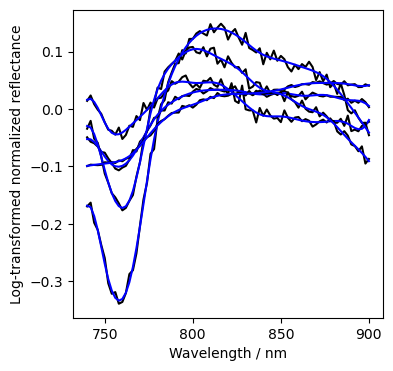

In [2]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_lsq_spline
from scipy.optimize import approx_fprime

degree = 3
n_knots = 14
central_knots = np.linspace(min(wls), max(wls), n_knots)
knots = np.r_[[min(wls)]*3, central_knots, [max(wls)]*3]

n_grads = 50
gradient_knots = np.linspace(min(wls), max(wls), 5)

def transform_data(y):
    y_prime = np.log(y)
    y_prime = y_prime - np.mean(y_prime)
    return y_prime

dist_i = 20
plt.figure(figsize=(4,4))
for key, e in islice(reflectances.items(), 5):
    y = transform_data(e[:, dist_i])
    spline = make_lsq_spline(wls, y, t=knots)
    
    plt.plot(wls, y, color='black')
    plt.plot(wls, spline(wls), color='blue')

plt.xlabel('Wavelength / nm')
plt.ylabel('Log-transformed normalized reflectance')
plt.show()

In [3]:
from sklearn.linear_model import LassoLarsIC

def generate_summary_statistics(distances, suffixes):
    summary_statistics = {k: {} for k in dirs}
    for key, e in reflectances.items():
        ys = [e[:, dist] for dist in distances]
        y_primes = [transform_data(y) for y in ys]

        splines = [make_lsq_spline(wls, y, t=knots) for y in ys]

        coeffs = np.array([y.c for y in splines])

        # spline coeffs for fits to y_prime
        for suffix, coeff in zip(suffixes, coeffs):
            summary_statistics[key]['spline_' + suffix] = coeff
        
        # gradients of spline fits at central_knots
        for suffix, y in zip(suffixes, splines):
            summary_statistics[key]['spline_gradient_' + suffix] = np.diag(approx_fprime(gradient_knots, y))
        
        # differences in log(mean) of y
        log_means = [np.log(np.mean(y)) for y in ys]
        summary_statistics[key]['log_mean'] = np.diff(log_means)
        
        for suffix, y in zip(suffixes, ys):
            summary_statistics[key]['mean_' + suffix] = np.mean(y)
            summary_statistics[key]['variance_' + suffix] = np.var(np.log(y))
            summary_statistics[key]['minimax_' + suffix] = np.array([np.max(y), np.min(y)])
            summary_statistics[key]['minimaxwl_' + suffix] = np.array([wls[np.argmax(y)], wls[np.argmin(y)]])
    
    return summary_statistics

def run_whole_thing(distances, df, target_col, extra_powers=[2]):
    suffixes = [str(e) for e in range(len(distances))]
    summary_statistics = generate_summary_statistics(distances, suffixes)

    def build_summary_stat_x(uuid):
        summary = summary_statistics[uuid]
        summary_stats = [np.atleast_1d(summary[key + '_' + suffix]) for key in ['variance', 'spline'] for suffix in suffixes] + [summary[key] for key in ['log_mean']]
        base_stats = np.concatenate(summary_stats)
        return np.concatenate([base_stats] + [np.power(base_stats, e) for e in extra_powers])
    
    for key in ['one', 'two']:
        df[f'oxy_blood_{key}'] = df[f'blood_{key}']*df[f'blood_sat_{key}']
        df[f'deoxy_blood_{key}'] = df[f'blood_{key}']*(1 - df[f'blood_sat_{key}'])
    df = df[[target_col, 'uuid']]

    df = df[df.loc[:, 'uuid'].apply(lambda uuid: uuid in reflectances)]
    df.loc[:, 'x'] = df.loc[:, 'uuid'].apply(build_summary_stat_x)

    y = np.zeros(len(df))
    mat = np.zeros((len(df), len(df['x'].iloc[0])))

    print('mat shape:', mat.shape)

    for i, (_, row) in enumerate(df.iterrows()):
        y[i] = row[target_col]
        mat[i, :] = row['x']

    model = LassoLarsIC(normalize=True).fit(mat, y)

    print("fit model with alpha_:", model.alpha_)
    print("AIC = ", np.min(model.criterion_))

    # matrix eqn y = mat @ beta

    #beta = np.linalg.pinv(mat) @ y
    beta = model.coef_

    # model y as mat @ beta

    summary_stat = mat @ beta

    df.loc[:, 'summary_stat'] = df.loc[:, 'x'].apply(lambda x: np.sum(x * beta) + model.intercept_)

    return y, summary_stat, df, model

def fit_gp(x, y):
    pass

mat shape: (207, 106)
fit model with alpha_: 0.00028061599072099803
AIC =  1466.159845882178


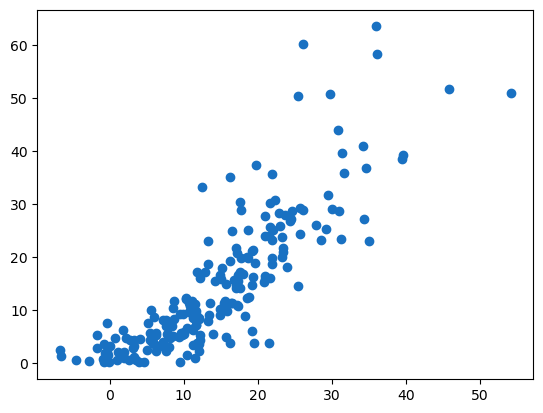

In [4]:
from constants.colors import colors

df = pd.read_csv('./sims/df.csv', index_col=0)

target = 'deoxy_blood_one'
y, summary_stat, df_, _ = run_whole_thing([40, 45, 50], df, target)

plt.figure()
plt.scatter(df_['summary_stat'], df_[target], color=colors['blue'][8])
plt.show()

In [27]:
point_style_kwargs = {
    "color": colors['blue'][8],
    "alpha": 0.7,
    "edgecolors": 'black'
}

def add_top_left_text(label, ax):
    t = ax.text(0.025, 0.975, label, verticalalignment='top', fontsize=14, transform=ax.transAxes)
    #t.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='black'))

def add_bottom_right_text(label, ax, fill=None, alpha=0.5, edgecolor='black'):
    t = ax.text(0.975, 0.025, label, verticalalignment='bottom', horizontalalignment='right', fontsize=12, transform=ax.transAxes)
    if fill is not None:
        t.set_bbox(dict(facecolor=fill, alpha=0.7, edgecolor=edgecolor))

def add_middle_left_text(label, ax, fill=None, alpha=0.5, edgecolor='black'):
    t = ax.text(0.025, 0.5, label, verticalalignment='center', horizontalalignment='left', fontsize=12, transform=ax.transAxes)
    if fill is not None:
        t.set_bbox(dict(facecolor=fill, alpha=0.7, edgecolor=edgecolor))

def fit_text(model):
    aic_string = f'AIC = {str(np.round(np.min(model.criterion_), 1))} '
    alpha_string = r'$\alpha = ' + '{:0.1e}'.format(model.alpha_).replace('e', 'x 10^{') + '}$'
    combined_string = '\n'.join([aic_string, alpha_string])

    return aic_string, alpha_string, combined_string

def pairwise(iterable, N=1):
    "s -> (s0, s1), (s2, s3), (s4, s5), ..."
    a = iter(iterable)
    b = iter(iterable)
    for _ in range(N-1):
        next(b)
    return zip(a, b)

# make the mean line smooth and add a legend to each figure for mean and std
def std_fill(ax, x, y, color):
    x = np.array(x)
    n_bins = 100
    bins = np.linspace(min(x), max(x), 100)
    epsilon = (max(x) - min(x)) / 10
    n_steps = int(epsilon / (bins[1] - bins[0]))
    print(f'epsilon = {epsilon}')
    bins_x = []
    bins_y = []
    std_y = []
    for lower, upper in pairwise(bins, N=n_steps):
        mask = (lower < x) & (x < upper)
        subset_x = x[mask]
        if len(subset_x) < 5:
            continue
        subset_y = y[mask]
        bins_y.append(np.mean(subset_y))
        std_y.append(np.std(subset_y))
        bins_x.append((lower + upper) / 2)
    
    fill = ax.fill_between(bins_x, np.array(bins_y) - np.array(std_y), np.array(bins_y) + np.array(std_y), color=color)

    return bins_x, bins_y, std_y, epsilon, fill

Creating a figure for CSF inference

mat shape: (207, 105)
fit model with alpha_: 1.1652777328897135e-05
AIC =  -11.715474340799432
epsilon = 0.07492079223309105
std_y = 0.0959428700356894 0.10082804377518195 0.0993414188468138 0.11849877164698358 0.10530461399236912 0.10717678362632316 0.12644139561796158 0.2090256977660387 0.22128263354430708 0.2294441103536549 0.2294441103536549 0.2331737639149353 0.22975839992568076 0.2218545773907706 0.2224991135707382 0.20685168942599674 0.20551135703099122 0.21437250001810132 0.22008150394127454 0.22707341136308867 0.2557362380919635 0.24571753293168921 0.23688239315945406 0.2338582974381359 0.24442357137486223 0.24671027131827677 0.2409848184052208 0.22522637625588837 0.2110259548645398 0.2271376031148364 0.22551502625033265 0.22603800270707722 0.19675351432151558 0.1846904552795734 0.18672171125056214 0.19150723368725883 0.2057534698718244 0.1981837106667809 0.2091920429604447 0.21120012853984746 0.20316648722412792 0.20588191683287377 0.17775022316138422 0.1899856354999985 0.185

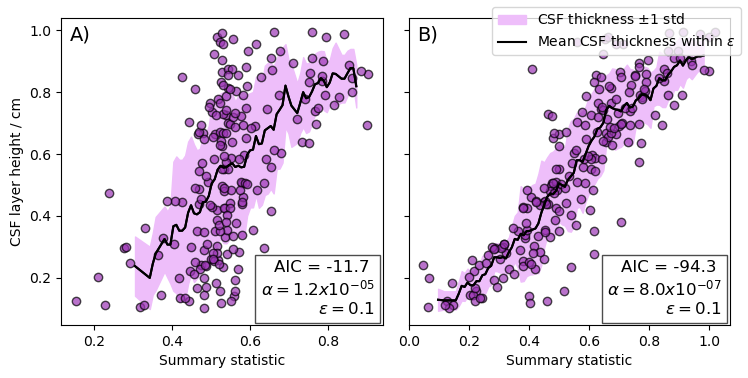

In [16]:
distances = [
    [40, 50],
    [40, 45, 50]
]

powers = [
    [2, 3],
    [2, 3]
]

labels = ['A)', 'B)']

target = 'height_csf'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 3.8), sharey='all')

lines = []
shading = []

for dist, power, ax, label in zip(distances, powers, axs, labels):
    _, _, df_, model = run_whole_thing(dist, df, target, extra_powers=power)
    x, y = df_['summary_stat'], df_[target]

    bins_x, bins_y, std_y, epsilon, fill = std_fill(ax, x, y, colors['grape'][2])
    print('std_y = ' + ' '.join([str(x) for x in std_y]))
    shading.append(fill)

    kwargs = point_style_kwargs.copy()
    kwargs['color'] = colors['grape'][8]
    ax.scatter(x, y, **kwargs)
    ax.set_xlabel('Summary statistic')
    add_top_left_text(label, ax)
    _, _, combined_string =  fit_text(model)
    add_bottom_right_text(combined_string + '\n' + r'$\epsilon =$' + str(round(epsilon, 1)), ax, fill='white')

    ax.plot(bins_x, bins_y, 'black')

    mean, = ax.plot(bins_x, bins_y, 'black')
    
fig.legend((shading[0], mean), (r'CSF thickness $\pm$1 std', r'Mean CSF thickness within $\epsilon$'))
axs[0].set_ylabel('CSF layer height / cm')
plt.tight_layout()
plt.savefig('./figure_generation/figures/csf_inference.png', dpi=600, transparent=True)
plt.savefig('./figure_generation/figures/csf_inference.pdf', dpi=600, transparent=True)
plt.show()

Apparent inference for skin skull layer

mat shape: (207, 68)
fit model with alpha_: 8.889285996371334e-06
AIC =  1652.069390085598
epsilon = 9.952562965870333
std_y = 1.749414251165732 2.0660340106043305 4.705831627633467 5.258340761539693 5.603865280238936 5.28899134185543 5.125066713299129 5.215256780039869 5.022582411687793 4.946155805745688 4.2073985935257525 3.814531175234565 3.772660363612924 3.713885643049803 5.892118225408131 6.695682292373314 6.738195726942055 6.302698412776769 6.357522884959124 6.7907848910156705 7.365664366352521 7.381844354447049 8.38241247541346 8.57229172495874 8.78765574490143 12.687981670723257 12.569434253697715 12.087308766488192 10.862658805372932 10.904937097803428 11.481774664489995 10.836668058180148 11.032999198243584 10.473960024300329 13.453296950106363 14.117771833052956 13.680870200292253 11.802557460341204 11.498281682063501 11.209420747810094 11.621929564457714 10.828878117528333 10.415764075296133 11.16021235352741 11.270198852604647 11.399578272767325 11.513024617839607 12.0167

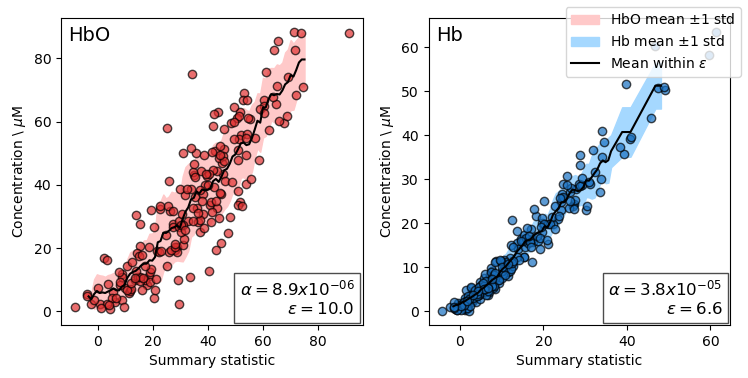

In [21]:
distances = [10]
powers = [2, 3, 4]

labels = ['HbO', 'Hb']
targets = ['oxy_blood_one', 'deoxy_blood_one']
scatter_colors = [colors['red'], colors['blue']]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(7.5, 3.8))

lines = []
shading = []

for ax, label, target, color in zip(axs, labels, targets, scatter_colors):
    _, _, df_, model = run_whole_thing(distances, df, target, extra_powers=powers)
    x, y = df_['summary_stat'], df_[target]

    bins_x, bins_y, std_y, epsilon, fill = std_fill(ax, x, y, color[2])
    print('std_y = ' + ' '.join([str(x) for x in std_y]))
    shading.append(fill)

    kwargs = point_style_kwargs.copy()
    kwargs['color'] = color[8]
    ax.scatter(x, y, **kwargs)
    ax.set_xlabel('Summary statistic')
    ax.set_ylabel(r'Concentration \ $\mu$M')
    add_top_left_text(label, ax)
    _, alpha_string, _ = fit_text(model)
    add_bottom_right_text(alpha_string + '\n' + r'$\epsilon =$' + str(round(epsilon, 1)), ax, fill='white')

    ax.plot(bins_x, bins_y, 'black')

fig.legend((shading[0], shading[1], mean), (r'HbO mean $\pm$1 std', r'Hb mean $\pm$1 std', r'Mean within $\epsilon$'))

plt.tight_layout()
plt.savefig('./figure_generation/figures/first_layer_inference.png', dpi=600, transparent=True)
plt.savefig('./figure_generation/figures/first_layer_inference.pdf', dpi=600, transparent=True)
plt.show()

Inference for 2nd layer oxygenated and deoxygenated blood with variable CSF

mat shape: (207, 105)
fit model with alpha_: 0.023398731677127374
AIC =  1859.2275299804585
epsilon = 3.5619993776428047
std_y = 20.268923373040877 22.210231792958304 23.113666958365627 23.113666958365627 23.113666958365627 24.439833977943515 24.98785584580627 22.395127510313845 18.599730543616385 17.05090906299962 17.56376779607461 17.62920246069892 21.46370948735647 21.003869293499246 21.324312244696575 21.664172641674885 22.89021020065275 22.83418262676428 22.137268113705066 21.889782787567423 21.149173668465995 21.504727020487653 20.933586796808708 21.139608935537307 21.912992098058293 21.363208969783628 21.709821030687525 21.33525787285427 21.510721937706787 21.53603347471334 22.16609152912782 20.53916922842938 18.558891764067702 19.32840967748071 19.229264792185038 18.82526932166129 19.128496988558066 18.89964053121903 18.521301533610718 17.639906013846524 19.41872209009727 17.70277810363452 18.006942038534355
mat shape: (207, 159)
fit model with alpha_: 0.02257740948392784
AIC =

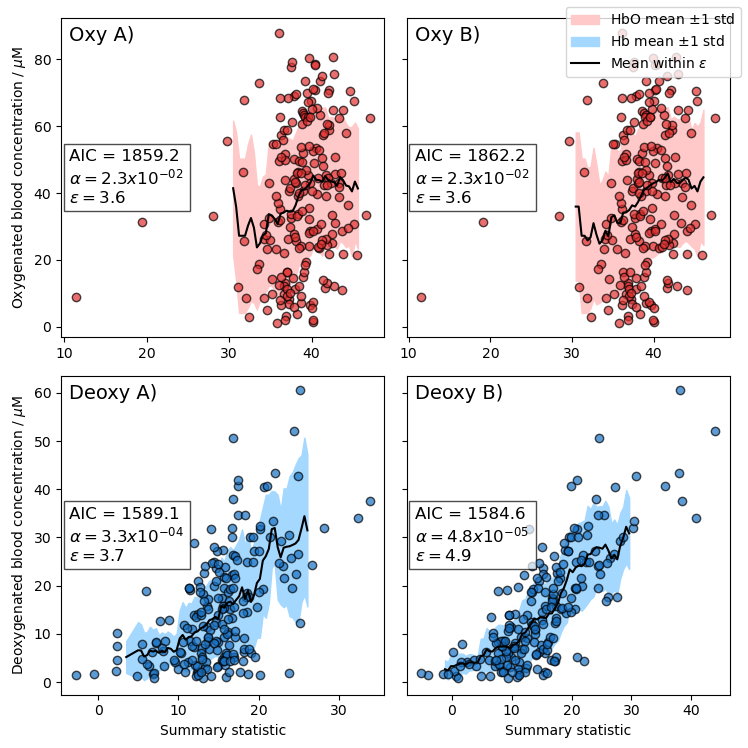

In [29]:
distances = [
    [40, 50],
    [40, 45, 50],
]

powers = [
    [2, 3],
    [2, 3],
]

labels = [['Oxy A)', 'Oxy B)'], ['Deoxy A)', 'Deoxy B)']]
scatter_colors = [colors['red'], colors['blue']]
targets = ['oxy_blood_two', 'deoxy_blood_two']
y_labels = [r'Oxygenated blood concentration / $\mu$M', r'Deoxygenated blood concentration / $\mu$M']

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(7.5, 7.5), sharey='row')

lines = []
shading = []

for i, ax_row in enumerate(axs):
    ax_row[0].set_ylabel(y_labels[i])
    for j, ax in enumerate(ax_row):
        _, _, df_, model = run_whole_thing(distances[j], df, targets[i], extra_powers=powers[i])
        x, y = df_['summary_stat'], df_[targets[i]]
        bins_x, bins_y, std_y, epsilon, fill = std_fill(ax, x, y, scatter_colors[i][2])
        shading.append(fill)
        print('std_y = ' + ' '.join([str(x) for x in std_y]))
        
        kwargs = point_style_kwargs.copy()
        kwargs['color'] = scatter_colors[i][8]
        ax.scatter(x, y, **kwargs)
        add_top_left_text(labels[i][j], ax)
        _, _, combined_string =  fit_text(model)
        add_middle_left_text(combined_string + '\n' + r'$\epsilon =$' + str(round(epsilon, 1)), ax, fill='white')
        if i == 1:
            ax.set_xlabel('Summary statistic')
        
        ax.plot(bins_x, bins_y, 'black')

fig.legend((shading[0], shading[2], mean), (r'HbO mean $\pm$1 std', r'Hb mean $\pm$1 std', r'Mean within $\epsilon$'))

plt.tight_layout()
plt.savefig('./figure_generation/figures/second_layer_inference.png', dpi=600, transparent=True)
plt.savefig('./figure_generation/figures/second_layer_inference.pdf', dpi=600, transparent=True)
plt.show()